# Prerequistite Packages

In [ ]:
# Just comment and uncomment as necessary
# The output is kinda annoying and crowded

# Install packages
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorflow


# Imports

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


# Magic Constants

In [ ]:
# Filename
FILE_PREFIX = "./data/"
train_filename = FILE_PREFIX + "train.csv"
test_filename = FILE_PREFIX + "test.csv"

# Scrap me: test.csv doesn't include the transported column! Should always be false
# Set to False if we want to only train and test on the train csv
loadSeparateTestCsv = False

# Set to true when we want to generate a submission for kaggle
testSubmission = True

# Common utility functions
def checkNotSubmitting():
    assert not testSubmission, "Don't run this cell if creating a submission"


# Load and Split the File

In [ ]:
# We might want to mount a shared google drive so we don't have to reupload
# everytime the session expires
trainData = pd.read_csv(train_filename)
data = None
testData = None
if loadSeparateTestCsv:
    testData = pd.read_csv(test_filename)
    data = pd.concat([trainData, testData])
else:
    data = trainData

if testSubmission:
    data = pd.read_csv(test_filename)

# FEATURE MODIFICATION SETTINGS
splitPassengerId = True # Set to true to generate two new features from the passengerId data
dropCols = ["PassengerId", "Name"]  # Columns to drop entirely
# Binary columns to replace with 1's and 0's
binaryCols = ["CryoSleep", "VIP", "Transported"]
# Category columns that are commonly shared, dummies are built from these
categoricalCols = []
# Ok my idea for this is that for the fairly unique columns we should generate a numerical
# id for each unique entry, then replace the column with the id. Generating dummies with these
# just leads to a feature explosion.
uniqueGeneratorCols = ["Cabin", "HomePlanet", "Destination"]
###############################

# Not sure why these features have NaN's, but we can (safely?) replace them with 0's.
data["CryoSleep"] = data["CryoSleep"].fillna(value=False)
data["VIP"] = data["VIP"].fillna(value=False)
data["VRDeck"] = data["VRDeck"].fillna(value=0)
data["ShoppingMall"] = data["ShoppingMall"].fillna(value=0)
data["RoomService"] = data["RoomService"].fillna(value=0)
data["FoodCourt"] = data["FoodCourt"].fillna(value=0)
data["Spa"] = data["Spa"].fillna(value=0)
# weird ones
data["Cabin"] = data["Cabin"].fillna(value="UNKNOWN")
data["HomePlanet"] = data["HomePlanet"].fillna(value="UNKNOWN")
data["Destination"] = data["Destination"].fillna(value="UNKNOWN")
data["Age"] = data["Age"].fillna(value=-1)

# test.csv doesn't have the transported column
if testSubmission and "Transported" in binaryCols:
    binaryCols.remove("Transported")
# We want to keep the passengerIds for submission
if testSubmission and "PassengerId" in dropCols:
    dropCols.remove("PassengerId")

if splitPassengerId:
  data["PassengerId_cabinNum"] = data.apply(lambda row: int(row["PassengerId"].split("_")[0]), axis=1)
  data["PassengerId_roomNum"] = data.apply(lambda row: int(row["PassengerId"].split("_")[1]), axis=1)

data = data.drop(columns=dropCols)
for c in binaryCols:
    data[c] = data[c].astype(int)
data = pd.get_dummies(data, columns=categoricalCols)
# Generate unique ids per column
for c in uniqueGeneratorCols:
    data[c] = data[c].astype("category").cat.rename_categories(
        range(data[c].nunique()))

# We don't want any nan data
assert (not data.isnull().values.any())

yCol = "Transported"
X, y = None, None
if not testSubmission:
    X = data.drop(columns=yCol)
    y = data[yCol]
else:
    X = data

X_train, X_test, y_train, y_test = None, None, None, None
if not testSubmission:
    if testData is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train = X[: trainData.shape[0]]
        X_test = X[trainData.shape[0]:]
        y_train = y[: trainData.shape[0]]
        y_test = y[trainData.shape[0]:]
else:
    X_test = X

# print(data.head())
# print(data.describe())


# Data Visualization

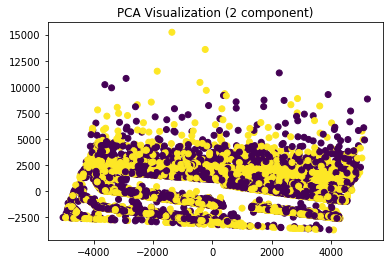

In [ ]:
# tSNE or PCA here

checkNotSubmitting()

pcaComps = 2
pca = PCA(n_components=pcaComps)
pca_train = pca.fit_transform(X_train, y_train)
pca_test = pca.transform(X_test)

if pcaComps == 2:
    plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.title(f"PCA Visualization ({pcaComps} component)")
plt.show()

# Feature importance graphing
# todo
estimators = 100  # todo: grid search me!
#gbc = GradientBoostingClassifier(n_estimators=100)
#gbc.fit(X_train, y_train)
# todo: render the important features
# look at my roommates code here: https://github.com/justincdavis/BowlGamesNN/blob/main/CFBowlGamesNN.ipynb


# Find Models

As we are predicting which passengers have been sent to the anomaly, this is naturally a classification problem.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Here, we'll explore supervised, classification models. Some are better than others.

In [ ]:
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report


## K Nearest Neighbors

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
best_n = 0
best_f1 = 0
best_predictions = 0

max_neighbors = 201
weights = ["distance", "uniform"]
for weight in weights:
    for n_neighbors in range(1, max_neighbors):
        clf = KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weight, n_jobs=-1).fit(X=X_train, y=y_train)

        predictions = clf.predict(X=X_test)
        f1 = f1_score(y_true=y_test, y_pred=predictions)

        if f1 > best_f1:
            best_f1 = f1
            best_n = n_neighbors
            best_predictions = predictions

    print(f"Weight: {weight}")
    print(classification_report(y_true=y_test, y_pred=best_predictions))


Weight: distance
              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1085
           1       0.69      0.85      0.77      1089

    accuracy                           0.74      2174
   macro avg       0.75      0.74      0.73      2174
weighted avg       0.75      0.74      0.73      2174

Weight: uniform
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1085
           1       0.71      0.85      0.77      1089

    accuracy                           0.75      2174
   macro avg       0.76      0.75      0.75      2174
weighted avg       0.76      0.75      0.75      2174



## SVCs

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
kernels = {'poly', 'rbf', 'sigmoid'}

for kernel in kernels:
    clf = SVC(kernel=kernel, gamma="scale").fit(X=X_train, y=y_train)
    predictions = clf.predict(X=X_test)

    print(f"Model: {clf}")
    print(f"Kernel: {kernel}")
    print(classification_report(y_true=y_test, y_pred=predictions))


Model: SVC()
Kernel: rbf
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1085
           1       0.71      0.90      0.80      1089

    accuracy                           0.77      2174
   macro avg       0.79      0.77      0.76      2174
weighted avg       0.79      0.77      0.76      2174

Model: SVC(kernel='sigmoid')
Kernel: sigmoid
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1085
           1       0.53      0.53      0.53      1089

    accuracy                           0.53      2174
   macro avg       0.53      0.53      0.53      2174
weighted avg       0.53      0.53      0.53      2174

Model: SVC(kernel='poly')
Kernel: poly
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      1085
           1       0.65      0.92      0.76      1089

    accuracy                           0.71      2174
   macro avg       

In [ ]:
clf = LinearSVC(penalty="l1", loss="squared_hinge",
                dual=False).fit(X=X_train, y=y_train)
predictions = clf.predict(X=X_test)

print(f"Model: {clf}")
print(classification_report(y_true=y_test, y_pred=predictions))

clf = LinearSVC(penalty="l2", dual=False).fit(X=X_train, y=y_train)
predictions = clf.predict(X=X_test)

print(f"Model: {clf}")
print(f"The f1 score is {f1_score(y_true=y_test, y_pred=predictions)}")
print(classification_report(y_true=y_test, y_pred=predictions))


Model: LinearSVC(dual=False, penalty='l1')
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1085
           1       0.77      0.79      0.78      1089

    accuracy                           0.78      2174
   macro avg       0.78      0.78      0.78      2174
weighted avg       0.78      0.78      0.78      2174

Model: LinearSVC(dual=False)
The f1 score is 0.7820976491862567
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1085
           1       0.77      0.79      0.78      1089

    accuracy                           0.78      2174
   macro avg       0.78      0.78      0.78      2174
weighted avg       0.78      0.78      0.78      2174



## Naive Bayes

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB

In [ ]:
naive_bayes_models = (GaussianNB(), BernoulliNB())
for model in naive_bayes_models:
    clf = model.fit(X=X_train, y=y_train)
    predictions = clf.predict(X=X_test)

    print(f"Model: {clf}")
    print(classification_report(y_true=y_test, y_pred=predictions))


Model: GaussianNB()
              precision    recall  f1-score   support

           0       0.85      0.45      0.59      1085
           1       0.63      0.92      0.75      1089

    accuracy                           0.69      2174
   macro avg       0.74      0.69      0.67      2174
weighted avg       0.74      0.69      0.67      2174

Model: BernoulliNB()
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1085
           1       0.78      0.65      0.71      1089

    accuracy                           0.73      2174
   macro avg       0.74      0.73      0.73      2174
weighted avg       0.74      0.73      0.73      2174



## Stochastic Gradient Descent

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [ ]:
losses = {'hinge', 'modified_huber', 'squared_hinge', 'perceptron',
          'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}
penalties = {'l2', 'l1', 'elasticnet'}


best_f1 = 0
best_SGD_model = SGDClassifier()
best_predictions = 0

for loss in losses:
    for penalty in penalties:
        clf = SGDClassifier(loss=loss, penalty=penalty,
                            max_iter=5000, n_jobs=-1).fit(X=X_train, y=y_train)
        predictions = clf.predict(X=X_test)

        f1 = f1_score(y_true=y_test, y_pred=predictions)

        if (f1 > best_f1):
            best_f1 = f1
            best_SGD_model = clf
            best_predictions = predictions

print(f"Best model: {best_SGD_model}")
print(classification_report(y_true=y_test, y_pred=predictions))


Best model: SGDClassifier(loss='perceptron', max_iter=5000, n_jobs=-1, penalty='l1')
              precision    recall  f1-score   support

           0       0.65      0.14      0.23      1085
           1       0.52      0.92      0.66      1089

    accuracy                           0.53      2174
   macro avg       0.58      0.53      0.45      2174
weighted avg       0.58      0.53      0.45      2174



## SVMs

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
# 2c_SL_SVM_Kernel.ipynb
# TODO SVM takes A REALLY LONG TIME (30+ and it didn't finish), even with reduced parameters
#      It was slow even on MIO, so not sure what to do there

# params = {
#     "kernel": ["linear", "poly"],
#     "degree": [1, 2, 3],
#     "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
#     "random_state": [0],
#     "gamma": ["auto"]
# }
# clf = GridSearchCV(estimator=SVC(), param_grid=params,
#                    scoring="f1_weighted", cv=10, n_jobs=-1)

# clf.fit(X=X_train, y=y_train)
# print(f"The best estimator is {clf.best_estimator_}")
# print(f"Best score on training data: {clf.best_score_}")

# testScore = clf.score(X=X_test, y=y_test)
# print(f"Best score on testing data: {testScore}")


# Feature selection

Feature selection is a feature learning approach to **select a subset of the features** from our data to use for a particular task.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression

checkNotSubmitting()

# References homework 4a_FL_Feature_Selection.ipynb
# Create a StandardScalar to standardize the passenger features
scalar = sk.preprocessing.StandardScaler().fit(X=X_train)
# Don't want to change the original values
XT_train = scalar.transform(X=X_train)
XT_test = scalar.transform(X=X_test)

In [ ]:
XT_submission = None
if testSubmission:
  XT_submission = scalar.transform(X_test.drop(columns=["PassengerId"]))

## Filter Methods (Mutual Information)

Filter methods directly **select a subset from the features** using a metric that they filter by.

An example filter method would be using the **mutual information score between features to determine the redundancy** in the data. 
With the goal of reducing dimensionality by minimizing redundancy we can then **remove features based on the highest amount of redundancy calculated by the mutual information.**

\+ Low computation cost

\+ Robust to overfitting. 

\+ Good value for computation time and effort 

\- Filter methods are also greedy which means that they may not get the best possible results.

In [ ]:
print(f"---------------------------------Mutual Information-------------------------------------")

# Create set of models to estimate on
model_estimators = [KNeighborsClassifier(n_neighbors=40, n_jobs=-1), SVC(kernel="rbf", gamma="scale"),
                    LinearSVC(dual=False, penalty="l1", max_iter=5000), GaussianNB(), BernoulliNB(), SGDClassifier(loss="perceptron", max_iter=5000, n_jobs=-1)]

# TEMP
fittedTransformer = None
fittedModel = None

# Select the best features based on mutual information score from the training data,
#  then transform XT_train and XT_test into the new subset of selected features
for model in model_estimators:
    print(f"Model: {model}")
    # Set up tracker variables
    best_k_MI = 0
    best_k_test = 0
    lowest_mse_MI = 1
    lowest_mse_test = 1
    best_predictions_MI = np.zeros(1)
    best_predictions_test = np.zeros(1)

    max_k = 11
    for k in range(1, max_k):
        mutual_information_transformer = sk.feature_selection.SelectKBest(
            score_func=sk.feature_selection.mutual_info_regression,
            k=k
        ).fit(X=XT_train, y=y_train)
        MI_X_train = mutual_information_transformer.transform(X=XT_train)
        MI_X_test = mutual_information_transformer.transform(X=XT_test)

        # Create model and estimate
        miEst = model.fit(X=MI_X_train, y=y_train)
        train_predictions = miEst.predict(X=MI_X_train)
        test_predictions = miEst.predict(X=MI_X_test)

        # TEMP
        if type(model) == SVC and k == 10:
          fittedTransformer = mutual_information_transformer
          fittedModel = miEst

        mse_MI = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)
        if (mse_MI < lowest_mse_MI):
            best_k_MI = k
            lowest_mse_MI = mse_MI
            best_predictions_MI = train_predictions
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            best_predictions_test = test_predictions

    print(f"Mutual Information bestK={best_k_MI}")
    print(classification_report(y_true=y_train, y_pred=best_predictions_MI))
    print(f"Testing Data bestK={best_k_test}")
    print(classification_report(y_true=y_test, y_pred=best_predictions_test))


---------------------------------Mutual Information-------------------------------------
Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=40)
Mutual Information bestK=9
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3230
           1       0.80      0.80      0.80      3289

    accuracy                           0.80      6519
   macro avg       0.80      0.80      0.80      6519
weighted avg       0.80      0.80      0.80      6519

Testing Data bestK=8
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1085
           1       0.78      0.80      0.79      1089

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

Model: SVC()
Mutual Information bestK=10
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3230
    

In [ ]:
if testSubmission:
  MI_submission = fittedTransformer.transform(XT_submission)
  submissionPreds = fittedModel.predict(MI_submission)
  outData = pd.DataFrame()
  outData["PassengerId"] = X_test["PassengerId"]
  outData["Transported"] = submissionPreds.astype(bool)
  outData.to_csv("results.csv", index=False)

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False


## Wrapper Methods (Recursive Feature Elimination)

Wrapper methods will **loop through the subset selection and model training stages.**

An example wrapper method is recursive feature elimination (RFE). RFE utilizes models that provide a coefficient for each feature that represents its applicability or use in determining the target of the model.

\+ Usually perform better than filter methods. 

\- They are also usually greedy methods, will 

\- Require more computation time than filter methods 

\- Prone to overfitting.

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet


In [ ]:
print(f"---------------------------------Recursive Elimination----------------------------------")

# RFE only works with LinearRegression-like models for some reason
model_estimators = [LinearRegression(
    n_jobs=-1), Ridge(), Lasso(), ElasticNet()]

for model in model_estimators:
    lowest_mse_rfe = 1
    lowest_mse_test = 1
    best_step_rfe = 0
    best_step_test = 0
    most_important_rfe = list()
    most_important_test = list()

    # Use recursive feature elimination (RFE) object to determine the k features to select
    # from X_train using a variable step size
    max_steps = 11
    for step in range(1, 11):
        rfe_transformer = sk.feature_selection.RFE(
            estimator=model, step=step).fit(X=XT_train, y=y_train)
        rfe_X_train = rfe_transformer.transform(X=XT_train)
        rfe_X_test = rfe_transformer.transform(X=XT_test)

        rfeEst = model.fit(rfe_X_train, y_train)
        train_predictions = rfeEst.predict(X=rfe_X_train)
        test_predictions = rfeEst.predict(X=rfe_X_test)

        mse_rfe = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)

        if (mse_rfe < lowest_mse_rfe):
            best_step_rfe = step
            lowest_mse_rfe = mse_rfe
            if splitPassengerId:
              most_important_rfe = list(
                data.columns[:13][rfe_transformer.support_])
            else:
              most_important_rfe = list(
                data.columns[:11][rfe_transformer.support_])
            
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            if splitPassengerId:
              most_important_test = list(
                data.columns[:13][rfe_transformer.support_])
            else:
              most_important_test = list(
                data.columns[:11][rfe_transformer.support_])

    print(f"Model: {model}")
    print(
        f"The lowest MSE for the RFE selected features is {lowest_mse_rfe} with step = {best_step_rfe}")
    if splitPassengerId:
      print(
        f"The most important features as determined by RFE were {list(data.columns[:13][rfe_transformer.support_])}")
    else:
      print(
        f"The most important features as determined by RFE were {list(data.columns[:11][rfe_transformer.support_])}")
    print(
        f"The lowest MSE for on the test data is {lowest_mse_test} with step = {best_step_test}\n")


---------------------------------Recursive Elimination----------------------------------
Model: LinearRegression(n_jobs=-1)
The lowest MSE for the RFE selected features is 0.1710331544794826 with step = 1
The most important features as determined by RFE were ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
The lowest MSE for on the test data is 0.17634410793803423 with step = 0

Model: Ridge()
The lowest MSE for the RFE selected features is 0.17103315627816032 with step = 1
The most important features as determined by RFE were ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
The lowest MSE for on the test data is 0.176343684292595 with step = 0

Model: Lasso()
The lowest MSE for the RFE selected features is 0.24997952225786443 with step = 1
The most important features as determined by RFE were ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'PassengerId_cabinNum']
The lowest MSE for on the test data is 0.2500121516447453

## Embedded Methods

Embedded methods will loop through the subset selection, model training and evaluation stages.

Based on the trained model parameters and performance, the embedded method will select a new subset. Examples of embedded feature selection methods are any of the regularization based regression methods we discussed previously.

\+ Enjoys benefits of filter and wrapper methods 

\+ Better performance and better results. 

\- More computation time.

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV


In [ ]:
print(f"---------------------------------Embedded Method----------------------------------")

# model_estimators = [RidgeCV, LassoCV]
model_estimators = [RidgeCV]
alphas = np.linspace(1, 100, 1000)

for model in model_estimators:

    max_alphas = 1001
    modelEst = model(alphas=alphas).fit(X=XT_train, y=y_train)

    train_predictions = modelEst.predict(XT_train)
    test_predictions = modelEst.predict(XT_test)

    mse_model = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)

    print(modelEst)
    print(f"The best mean squared error when training is {mse_model}")
    print(f"The best mean squared error on the test data is {mse_test}\n")


---------------------------------Embedded Method----------------------------------
RidgeCV(alphas=array([  1.        ,   1.0990991 ,   1.1981982 ,   1.2972973 ,
         1.3963964 ,   1.4954955 ,   1.59459459,   1.69369369,
         1.79279279,   1.89189189,   1.99099099,   2.09009009,
         2.18918919,   2.28828829,   2.38738739,   2.48648649,
         2.58558559,   2.68468468,   2.78378378,   2.88288288,
         2.98198198,   3.08108108,   3.18018018,   3.27927928,
         3.37837838,   3.47747748,   3.57657658,   3.67567568,
         3.77477477,   3.87387387,   3.97297297,...
        96.92792793,  97.02702703,  97.12612613,  97.22522523,
        97.32432432,  97.42342342,  97.52252252,  97.62162162,
        97.72072072,  97.81981982,  97.91891892,  98.01801802,
        98.11711712,  98.21621622,  98.31531532,  98.41441441,
        98.51351351,  98.61261261,  98.71171171,  98.81081081,
        98.90990991,  99.00900901,  99.10810811,  99.20720721,
        99.30630631,  99.405405

# Feature Extraction

In [ ]:
from sklearn.manifold import SpectralEmbedding

checkNotSubmitting()


## Spectral Embedding + SVC

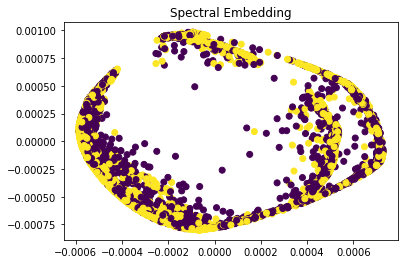

The Spectral Embedding + Linear SVM scores an F-1 = 0.667.


In [ ]:
# Justin: This is copied from 4b_FL_Feature_Extraction.ipynb
#         We can toy around to make it better, but this is a start

spectral_transformer = SpectralEmbedding().fit(X=X_train, y=y_train)
spectral_embedding = spectral_transformer.embedding_
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=y_train)
plt.title("Spectral Embedding")
plt.show()

X_complete = pd.concat([X_train, X_test])
size_Xtrain = len(X_train)

spectral_model = SpectralEmbedding()
spectral_train = spectral_model.fit_transform(
    X=X_complete[:size_Xtrain], y=y_train
)
spectral_test = spectral_model.fit_transform(
    X=X_complete[size_Xtrain:], y=y_test
)

spectral_svc = LinearSVC().fit(X=spectral_train, y=y_train)
print(
    f"The Spectral Embedding + Linear SVM scores an F-1 = {f1_score(y_test, spectral_svc.predict(spectral_test)):.3f}.")


## t-SNE + SVC

## LDA + SVC

# Model Testing

Now we have the reduced dataset with high mutual information between each feature, time to run some models


In [ ]:
# knn or svm?
# Justin: I think that KNN performed fairly well in the Filter + Mutual
#         Information testing
#         For the SVMs, they performed relatively well, but the f1 scores weren't
#         nearly as close to the KNN
#         One thing to note is that I ran the models on the original dataset and some
#         on the transformed/normalized dataset
#         Does it matter? Maybe.
#
# TODO    Test it out alone or in combination with other methods.
# TODO    Run the same models on the reduced or extracted datasets

checkNotSubmitting()


# Neural network

We can never go wrong with a neural network.

So far, this is the highest scoring model. However, we can probably get better
scores by tweaking the number of nodes in each layer, number of dropout layers,
etc.

In [ ]:
# Neural network

def BuildNetwork(silent=False):
  # Andrew's model arch notes:
  # - do we progressively collapse when autoencoding or dense map straight to it?
  # - mess around with dropout layers to reduce overfitting
  #   - hmm I think im doing something wrong, getting very little variation
  # - verified test labels are split ~50% live/die
  # - adding neurons to dense layers has little/no impact after ~8

  checkNotSubmitting()

  layers = []
  layers.append(tf.keras.layers.Dense(hiddenExpansionSize, input_shape=(X.shape[1],), activation=activation, name=f"input_{X.shape[1]}x1"))
  for i in range(denseHiddenLayers):
    if useDropOutLayers:
      layers.append(tf.keras.layers.Dropout(dropoutRate, name=f"dropout_{i}"))
    layers.append(tf.keras.layers.Dense(hiddenExpansionSize, activation=activation, name=f"dense_{i}"))
  layers.append(tf.keras.layers.Dense(autoencoderCompressionSize, activation=activation, name="autoenc")) # Compressed feature space
  #layers.append(tf.keras.layers.Dense(hiddenExpansionSize, activation=activation, name=f"autodec")) # Decompress
  #layers.append(tf.keras.layers.Dense(2, activation=outputActivation, name="output")) # Non-BCE loss function
  layers.append(tf.keras.layers.Dense(1, activation=outputActivation, name="output")) # BCE loss function

  dnn = tf.keras.Sequential(layers)
  dnn.build()
  if not silent:
    dnn.summary()

  nnDefaultWeights = dnn.get_weights()

  return dnn, nnDefaultWeights

In [ ]:
# Neural network compilation and training

def TrainNetwork(dnn, defaultWeights, silent=False):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
  #optimizer = tf.keras.optimizers.SGD()
  dnn.compile(optimizer, loss=lossFunc, metrics=["accuracy", "mse"])
  dnn.set_weights(defaultWeights) # Reset if we already fit
  return dnn.fit(X_train, y_train, batch_size=batchSize, epochs=epochs, verbose=(not silent))

def TestNetwork(dnn):
  nnMetrics = dnn.evaluate(X_test, y_test)
  return nnMetrics[1]

def GenerateKaggleSubmission(dnn):
  predictions = dnn.predict(X_test.drop(columns=["PassengerId"]), batch_size=batchSize)
  # We have 2 output nodes, we want to take the index of the node with greater activation
  #predictionsBinary = np.argmax(predictions, axis=1)
  #predictionsBinary = 1 - predictionsBinary # Invert the result for non-BCE loss
  # Single node output, convert confidence value to 0 or 1
  predictionsBinary = np.where(predictions > 0.5, 1, 0)
  outData = pd.DataFrame()
  outData["PassengerId"] = X_test["PassengerId"]
  outData["Transported"] = predictionsBinary.astype(bool)
  outData.to_csv("results.csv", index=False)

def GraphHistory(history, n_epochs):
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(np.arange(1, n_epochs+1), history.history['loss'])
  plt.title('Training set loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(1, 2, 2)
  plt.semilogy(np.arange(1, n_epochs+1), history.history['accuracy'], label='acc')
  plt.semilogy(np.arange(1, n_epochs+1), history.history['mse'], label='mse')
  plt.legend()
  plt.title('Training set metric scores')
  plt.xlabel('Epoch')
  plt.ylabel('Performance')

## Model Parameters

Epoch 1/75
204/204 [==============================] - 2s 2ms/step - loss: 0.7012 - accuracy: 0.5051 - mse: 0.2539
Epoch 2/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5272 - mse: 0.2495
Epoch 3/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5516 - mse: 0.2486
Epoch 4/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5749 - mse: 0.2468
Epoch 5/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.5952 - mse: 0.2420
Epoch 6/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6459 - accuracy: 0.6426 - mse: 0.2268
Epoch 7/75
204/204 [==============================] - 0s 2ms/step - loss: 0.6079 - accuracy: 0.6886 - mse: 0.2092
Epoch 8/75
204/204 [==============================] - 0s 2ms/step - loss: 0.5861 - accuracy: 0.7016 - mse: 0.1993
Epoch 9/75
204/204 [==============================] - 0s 2ms/step - loss: 0.5678 - accur

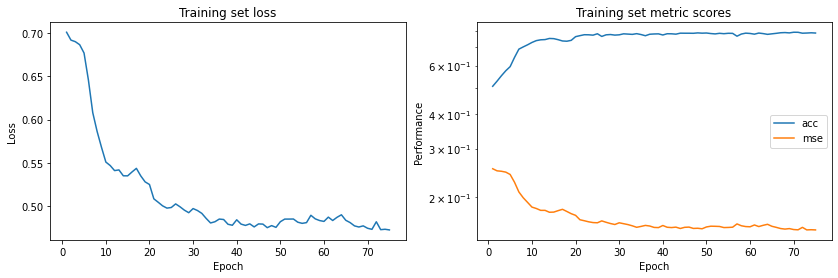

In [ ]:
# NEURAL NET CONFIG

# MODEL PARAMETERS
activation = "sigmoid"
outputActivation = "sigmoid" # This should not change
hiddenExpansionSize = 16 # Adding more than about 8 doesn't have much benefit
denseHiddenLayers = 2 # No measured benefit of >1, just takes longer to train? Acc falloff at high values
useDropOutLayers = False
dropoutRate = 0.04 # Dropout rate barely seems to affect the model performance
autoencoderCompressionSize = 6
##############################################################

# TRAINING PARAMETERS
learningRate = 0.001
lossFunc = "binary_crossentropy" # "mae"
# Note about the loss function: we want BCE for binary classification, but if we
# want to mess around with MAE or others, we need the network to end with 2 nodes
# and use a sigmoid activation.
epochs = 75#38
batchSize = None #1000
##############################################################

# Accuracy milestones
#######################
# Initial model: 0.8031
# Dropout model: 0.8068

# Basic network usage and testing:
# BuildNetwork()
# TrainNetwork()
# accuracy = TestNetwork()

dnn = None
if not testSubmission:
  # Optimizing parameters
  acc = []
  #sizes = [ 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8 ]
  #for i, s in enumerate(sizes):
  #  dropoutRate = s
  #  dnn, dWeights = BuildNetwork(silent=True)
  #  TrainNetwork(dnn, dWeights, silent=True)
  #  accuracy = TestNetwork(dnn)
  #  #print(f"ACCURACY: {accuracy}")
  #  acc.append((s,accuracy))
  #print("\n\nACCURACY VALUES:")
  #for i,v in acc:
  #  print(f"\ti={i}: {v}")
  dnn, dWeights = BuildNetwork(silent=True)
  history = TrainNetwork(dnn, dWeights, silent=False)
  GraphHistory(history, epochs)
  accuracy = TestNetwork(dnn)
  print(f"ACCURACY: {accuracy}")
else:
  if dnn is None:
    print("Failed to generate NN submission, did not train network")
  else:
    GenerateKaggleSubmission(dnn)